# Alternative hypothesis testing and model selection

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from gammapy.maps import Map
from gammapy.datasets import Datasets
from gammapy.modeling import Fit, select_nested_models
from gammapy.modeling.models import Models, PointSpatialModel, PowerLawSpectralModel, SkyModel
from gammapy.estimators import TSMapEstimator

from gammapy.stats.utils import ts_to_sigma
from gammapy.utils import pbar


First we load the datasets and the models from the last tutorial. 

In [2]:
datasets = Datasets.read(
    filename="./datasets/joint_datasets.yaml",
    filename_models="./models/models_joint_main_only.yaml"
)


Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1
Parameter 'value' not defined in YAML file. Using default value: 1.0 sr-1


We are going to downsample the datasets so the fit is faster.
Currently the pixel width is 0.02 degree while the best PSF R68 is about 0.1 degree resolution for most of the datasets.
So we can reasonnably donsample by a factor 5. 

In [3]:
models = datasets.models

factor=5
datasets = Datasets([d.downsample(factor=factor, name=d.name) for d in datasets])
datasets.models = models

HDU 'MASK_FIT' not found


We also load the candidate objects with haven't fitted yet:

In [4]:
candidate_models_sub = Models.read("./models/candidate_models_sub.yaml")

candidate_ordered = ["Seed_7", "Seed_2" ,  "Seed_6", "Seed_0"]#, "Seed_9" #last one has TS<10
#candidate_ordered = ["Seed_2" , "Seed_0", "Seed_7", "Seed_9", "Seed_6"]


# The various detection TS

How to define the significance of a new detection ?

This is not that trivial because depending on the modelling stage and the parameters left free the statistical question asked is not exaclty the same.

## New component TS

We can compute the TS improvement by adding a new component testing N vs. N+1 models.

First we compute the stat_sum for the null hypothesis which is the current models state.


In [5]:
stat_null = datasets.stat_sum()

Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


We select the candidate where there was the most significant excess leftover

In [6]:
new_model = candidate_models_sub[candidate_ordered[0]]


 and freeze the sources not overlapping with the candidate. 

In [7]:
datasets.models.freeze()

geom = datasets[0].counts.geom
skycoords = geom.get_coord().skycoord

is_overlapping = np.zeros(len(datasets.models), dtype=bool)
for km, m in enumerate(datasets.models):  
    if not m.spatial_model:
        continue
    elif "const" in m.spatial_model.tag or "template" in  m.spatial_model.tag:
        m.parameters["norm"].frozen = True
    else:
        intersection = m.spatial_model.to_region().intersection(new_model.spatial_model.to_region())
        is_overlapping[km] = np.sum(intersection.contains(skycoords, geom.wcs)) > 0

datasets.models[is_overlapping].unfreeze()

print("Sources overlapping : \n", datasets.models[is_overlapping].names)

Sources overlapping : 
 ['HESS J1713-397']


In [8]:
datasets.models = datasets.models + new_model

In [9]:
nfree = len(datasets.models.parameters.free_parameters)
print("Number of free parameters", nfree)

Number of free parameters 14


Now we can fit the new model

In [10]:
start_time =time.time()

#optimize_opts = dict(tol=0.1, strategy=1) #default
optimize_opts = dict(tol=1, strategy=0, migrad_opts={"ncall": 150*nfree}) #faster but less precise
fit = Fit(optimize_opts=optimize_opts)

result = fit.run(datasets=datasets)

print(result)

time_elapsed = time.time() - start_time
print("Fit time (min):", time_elapsed/60.)

Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 622
	total stat : 81643.52

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Fit time (min): 1.403084929784139


and compute TS and the significance of the new component given the extra number of parameters fitted.

In [11]:
stat_new = datasets.stat_sum()
TSnew =  stat_null - stat_new
dof=len(new_model.parameters.free_parameters)
sigma_new = ts_to_sigma(TSnew, dof)
print("TS detection", TSnew)
print(f"Significance (ndof) : {sigma_new} ({dof})" )


TS detection 28.189146868578973
Significance (ndof) : 3.715009477154342 (7)


In [12]:
new_models = Models()
if TSnew > 10:
    new_models.append(new_model)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,


<WCSAxes: >

/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


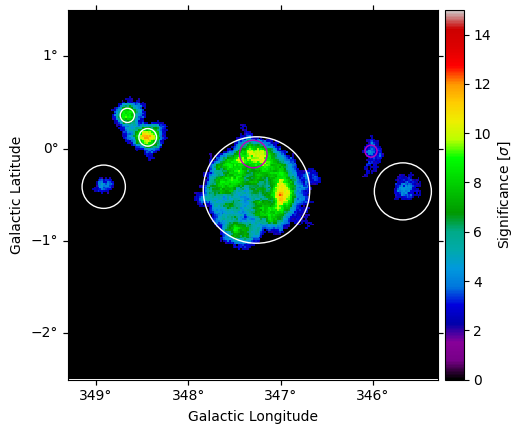

In [13]:
sig_rcorr0p1_fil_cut = Map.read("./maps/sig_rcorr0p1_fil_cut.fitd.gz")
resi_fil_kwargs = dict(
    clim=[0, 15],
    cmap=plt.cm.nipy_spectral,
    add_cbar=True,
    kwargs_colorbar={"label": r"Significance [$\sigma$]"})

sig_rcorr0p1_fil_cut
ax = sig_rcorr0p1_fil_cut.plot(**resi_fil_kwargs)

sources_hess = Models(datasets.models.select(name_substring="HESS")) + Models(datasets.models.select(name_substring="HGPSC"))
sources_hess.plot_regions(ax=ax, color="w")
datasets.models.select(name_substring="Seed").plot_regions(ax=ax, color="m")

Lets'put this all together and perform the computation for the other candidates 

Seed_2
Sources overlapping : 
 ['HESS J1713-397']
Number of free parameters 14


Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 717
	total stat : 81619.63

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Fit time (min): 1.8144269665082295
TS detection 23.884616841067327
Significance (ndof) : 3.2403597675956703 (7)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/

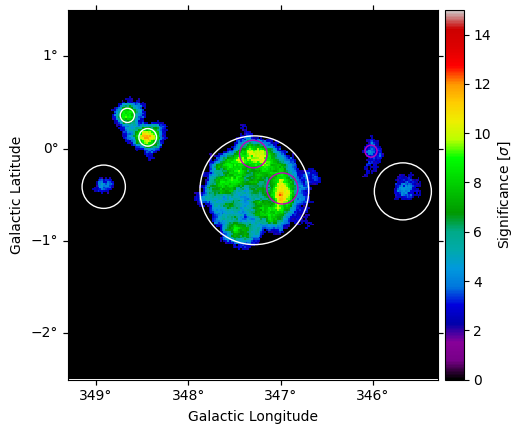

Seed_6
Sources overlapping : 
 ['HESS J1713-397']
Number of free parameters 14


Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 1367
	total stat : 81594.45

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Fit time (min): 3.22093079884847
TS detection 25.18276139241061
Significance (ndof) : 3.3879333363900423 (7)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/

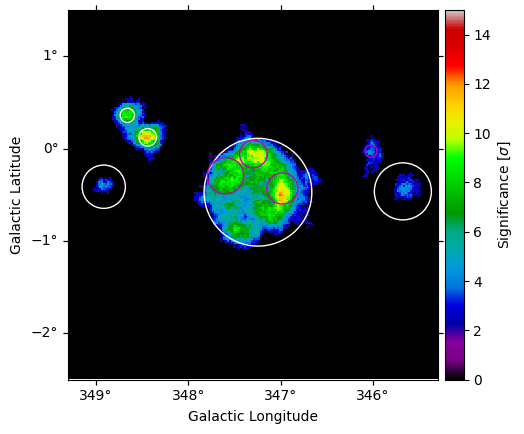

Seed_0
Sources overlapping : 
 ['HESS J1713-397']
Number of free parameters 14


Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 566
	total stat : 81559.59

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.

Fit time (min): 1.4641191800435385
TS detection 34.856544480484445
Significance (ndof) : 4.379402374543889 (7)


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/

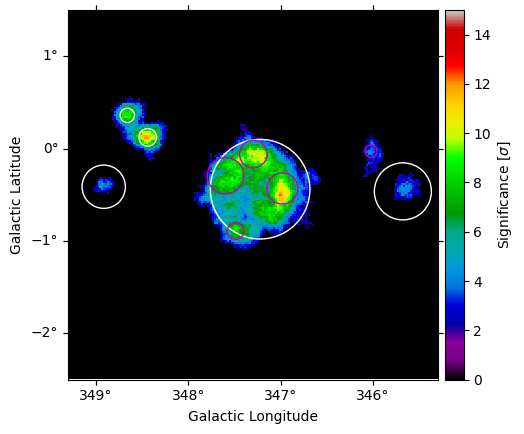

In [14]:
def iterative_fitting(new_model):
    print(new_model.name)

    stat_null = datasets.stat_sum()
    datasets.models.freeze()

    geom = datasets[0].counts.geom
    skycoords = geom.get_coord().skycoord
    
    is_overlapping = np.zeros(len(datasets.models), dtype=bool)
    for km, m in enumerate(datasets.models):  
        if not m.spatial_model:
            continue
        elif "const" in m.spatial_model.tag or "template" in  m.spatial_model.tag:
            m.parameters["norm"].frozen = True
        else:
            intersection = m.spatial_model.to_region().intersection(new_model.spatial_model.to_region())
            is_overlapping[km] = np.sum(intersection.contains(skycoords, geom.wcs)) > 0
    
    datasets.models[is_overlapping].unfreeze()
    
    print("Sources overlapping : \n", datasets.models[is_overlapping].names)

    datasets.models = datasets.models + new_model

    print("Number of free parameters", len(datasets.models.parameters.free_parameters))

    start_time =time.time()

    optimize_opts = dict(tol=1, strategy=0, migrad_opts={"ncall": 150*nfree})
    fit = Fit(optimize_opts=optimize_opts)
    
    result = fit.run(datasets=datasets)
    
    print(result)
    
    time_elapsed = time.time() - start_time
    print("Fit time (min):", time_elapsed/60.)

    stat_new = datasets.stat_sum()
    TSnew =  stat_null - stat_new
    dof=len(new_model.parameters.free_parameters)
    sigma_new = ts_to_sigma(TSnew, dof)
    print("TS detection", TSnew)
    print(f"Significance (ndof) : {sigma_new} ({dof})" )

    if TSnew<10:
        mods = Models(datasets.models)
        mods.remove(new_model)
        datasets.models = mods
    else:
        new_models.append(new_model)

        sig_rcorr0p1_fil_cut = Map.read("./maps/sig_rcorr0p1_fil_cut.fitd.gz")
        resi_fil_kwargs = dict(
            clim=[0, 15],
            cmap=plt.cm.nipy_spectral,
            add_cbar=True,
            kwargs_colorbar={"label": r"Significance [$\sigma$]"})
        
        sig_rcorr0p1_fil_cut
        ax = sig_rcorr0p1_fil_cut.plot(**resi_fil_kwargs)
        
        sources_hess.plot_regions(ax=ax, color="w")
        datasets.models.select(name_substring="Seed").plot_regions(ax=ax, color="m")
        plt.show()

for name in candidate_ordered[1:]:
    iterative_fitting(candidate_models_sub[name])

## Source TS in the final model

The TS computed iteratively by adding new components don't take into account the sources added afterward so the first components TS will be biased upward. Moreover during the iterative fitting the overlaping components were modified at each iteration.

Alternatively we can compute the TS in the final model by removing each of them individually. In that case the reference hypothesis, the global model, remains the same for all objects.

Depending on which other models we choose to let free we can test the sensitivity of the detection to the specific components:
- keeping everything else frozen implicitly assumes that the global model is a good representation of the true model
  and in that case it should tend toward the TS obtained in the Asimov dataset (counts=predicted counts),
  if not the goodness-of-fit is insufficiant.
- letting only the bkg or iem free inform us about confusion with large scale or diffuse emission,
- lettting the other sources free can tell us about source confusion issues,



### Detection TS in the asimov dataset

The Asimov dataset is the ideal case assuming that the global model is the true model. So if the source doesn't pass the detection threshold in that case further hypothessis testing is not even necessary, and this can save use a lot of time.

In [15]:
%%time 
datasets_asimov = datasets._to_asimov_datasets()

stat_sum_asimov = datasets_asimov.stat_sum()
stat_sum = datasets.stat_sum()

for model in pbar.progress_bar(new_models, desc="TS computation"):
    with datasets_asimov.models.parameters.restore_status(restore_values=True):
        model.parameters["amplitude"].value = 0
        
        stat_null_asimov = datasets_asimov.stat_sum()
        stat_null = datasets.stat_sum()

        ts_asimov =  stat_null_asimov  - stat_sum_asimov 
        ts_null =  stat_null - stat_sum

    print(f"{model.name}: TSnull_asimov = ", ts_asimov, " TSnull = ", ts_null)

Seed_7: TSnull_asimov =  41.858791133592604  TSnull =  64.349529194762
Seed_2: TSnull_asimov =  33.50552863466146  TSnull =  41.461980976338964
Seed_6: TSnull_asimov =  41.21194499214471  TSnull =  52.640603193984134
Seed_0: TSnull_asimov =  39.85526776415645  TSnull =  42.81652494054288
CPU times: user 2.27 s, sys: 38.1 ms, total: 2.31 s
Wall time: 2.31 s


### Detection TS against backgrounds

In [16]:
%%time
pbar.SHOW_PROGRESS_BAR = True
results = []
datasets.models.unfreeze()
for model in pbar.progress_bar(new_models, desc="TS computation"):
    with datasets.models.parameters.restore_status(restore_values=True):
        # this `with` statement restores the source parameters after each fit
        # so the global model remain the same to estimate to detection significance of each source.
        
        # Number of parameters previously fit for the source of interest
        n_free_parameters = len(model.parameters.free_parameters)

        # Freeze spatial parameters (or at minima lon_0 or lat_0 paramters)
        # in order to ensure that another weaker source does not move from its position
        # to replace the source of interest during the null hypothesis test.
        # (with all parameters free you test N vs. N+1 models and not the detection of a specific source.)
        datasets.models.freeze(model_type='spatial')

        # Define the status of the other models
        # For simplicity we freeze the other sources and let only bkg and iem free (otherwise it takes 20 min).
        # If this test doesn't pass the threshold there is no point in trying more time consuming tests.
        datasets.models.freeze()
        for p in datasets.models.parameters:
            if p.name in ["norm"]:
                p.frozen = False
                p.min = 0
        
        result = select_nested_models(datasets,
                                      parameters=[model.spectral_model.amplitude],
                                      null_values=[0],
                                      n_free_parameters=n_free_parameters,
                                      n_sigma=4,
                                      )
        result["name"] = model.name
        result["df"] = n_free_parameters
        result["sigma"] = ts_to_sigma(ts=result["ts"], df=n_free_parameters)
        results.append(result)
        print(model.name,
              f': ts={result["ts"]:.2f},',
              f'degree of freedom={n_free_parameters},',
              f'{result["sigma"]:.2f} sigma detection',
             )

pbar.SHOW_PROGRESS_BAR = False

TS computation:   0%|          | 0/4 [00:00<?, ?it/s]

Seed_7 : ts=67.92, degree of freedom=7, 6.94 sigma detection
Seed_2 : ts=42.33, degree of freedom=7, 5.05 sigma detection
Seed_6 : ts=54.08, degree of freedom=7, 5.98 sigma detection
Seed_0 : ts=43.18, degree of freedom=7, 5.12 sigma detection
CPU times: user 2min 8s, sys: 1.94 s, total: 2min 10s
Wall time: 2min 10s


## Testing sources properties

Now let's test the properties of one of the source: 
- is the spectral curvature is significant ?
- is the extension significant ?
- is the ellipticty significant

Again we can use `~gammapy.modeling.select_nested_models` \
But first we are going to freeze the other models for simplicity:

In [17]:
%%time
def alternatibe_models_tests(test_model):
    print(test_model.name)
    with datasets.models.restore_status(restore_values=False): #restore covariance and frozen status on exit
        for m in datasets.models:
            if m.name !=  test_model.name:
                m.freeze()
            else:
                m.unfreeze()

        #Spectral curvature test
        result_curvature = select_nested_models(datasets,
                                      parameters=[test_model.spectral_model.beta],
                                      null_values=[0.],
                                      n_sigma=2,
                                      )
    
        print("TS curvature", result_curvature["ts"])
        
        m_spatial = test_model.spatial_model

        #Extension test
        result_extension = select_nested_models(datasets,
                                  parameters=[m_spatial.r_0], 
                                  null_values=[1e-2],# here we set a very small radius (below the instrument resolution)
                                  n_sigma=2, 
                                  )
        
        print("TS extension", result_extension["ts"])

        if result_extension["ts"]>10: #we don't test ellipticity if extension is not detected
            #Ellipticity test
            result_ellipticity = select_nested_models(datasets,
                                      parameters=[m_spatial.e, m_spatial.phi],
                                      null_values=[0.,0.],
                                      n_sigma=2, #we set 2 sigma to switch to a more complex models
                                      )
    
            print("TS ellipticity", result_ellipticity["ts"])
        

for test_model in new_models:
    alternatibe_models_tests(test_model)


Seed_7
TS curvature 3.7826568410819164
TS extension 15.708993482330698
TS ellipticity -6.632035365328193e-07
Seed_2
TS curvature 0.3711570826708339
TS extension 2.528763507041731
Seed_6
TS curvature 5.681745207228232
TS extension 22.023374790893286
TS ellipticity 2.6446044310432626
Seed_0
TS curvature 5.648639302860829
TS extension -0.019543661255738698
CPU times: user 15min 37s, sys: 12.4 s, total: 15min 50s
Wall time: 15min 51s


## Diagnotics plots

Once we are done with the modeling we can look-up at a number of diagnostics plots to check the fit quality and results.

We can plot the residual significance distribution compared to the expected normal distribution using `~gammapy.visualization.plot_distribution`

First we compote the residual TS map.

In [18]:
spatial_model = PointSpatialModel()
spectral_model = PowerLawSpectralModel(index=2)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)

ts_estimator = TSMapEstimator(
    model,
    kernel_width="1 deg",  # this set close to the 95-99% containment radius of the PSF
    selection_optional=[],
    sum_over_energy_groups=True,
    energy_edges=[10, 1000] * u.GeV,
    n_jobs=4, #this will run in parallel
)

ts_results_all_with_new_source=ts_estimator.run(datasets)


Position <SkyCoord (ICRS): (ra, dec) in deg
    (255.02960205, -40.22290039)> is outside valid IRF map range, using nearest IRF defined within


/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/regions/shapes/ellipse.py:209: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  return Ellipse(xy=xy, width=width, height=height, angle=angle,
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/numpy/lib/_function_base_impl.py:2553: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/qremy/anaconda3/envs/gpy-dev-test/lib/python3.11/site-packages/

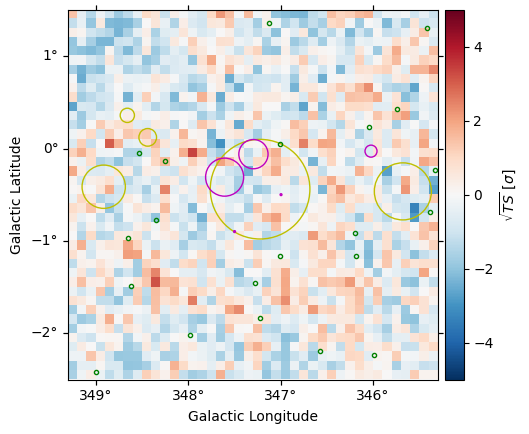

In [19]:
resi_kwargs =dict(
        clim=[-5, 5],
        cmap=plt.cm.RdBu_r,
        add_cbar=True,
        kwargs_colorbar={"label": r"$\sqrt{TS}$ [$\sigma$]"},
    )

image = ts_results_all_with_new_source["sqrt_ts"]
image = image.cutout(
    image.geom.center_skydir, width=np.max(image.geom.width) - 2 * 2*u.deg
)
ax = image.plot(**resi_kwargs)


sources_hess = Models(datasets.models.select(name_substring="HESS")) + Models(datasets.models.select(name_substring="HGPSC"))
sources_hess.plot_regions(ax=ax, color="y")
datasets.models.select(name_substring="Seed").plot_regions(ax=ax, color="m")
datasets.models.select(name_substring="4FGL").plot_regions(ax=ax, color="g", kwargs_point=dict(marker="."))
plt.show()

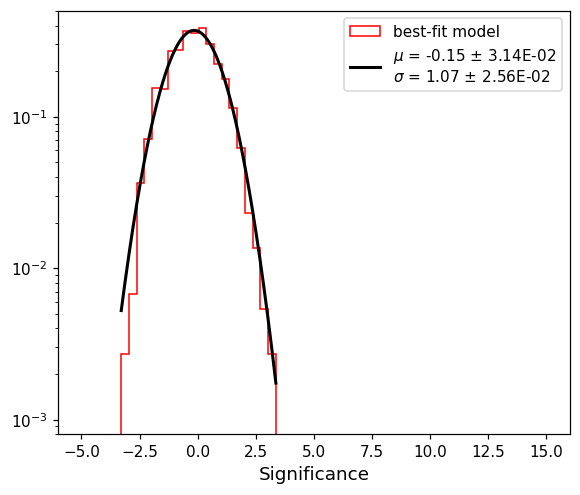

In [20]:
from gammapy.visualization import plot_distribution

fig, ax = plt.subplots(figsize=(6,5), dpi=110)
plot_distribution(ts_results_all_with_new_source["sqrt_ts"],
                  func='norm',
                  ax=np.array([ax]),
                  kwargs_hist=dict(histtype="step", color="r",bins=20, density=True, label="best-fit model"),
                 )


ax.set_yscale('log')
yl=ax.get_ylim()
ax.set_ylim([8e-4, yl[1]])
ax.set_xlim([-6, 16])

ax.set_xlabel("Significance", fontsize=12)
plt.show()

Let's plot all source spectral models

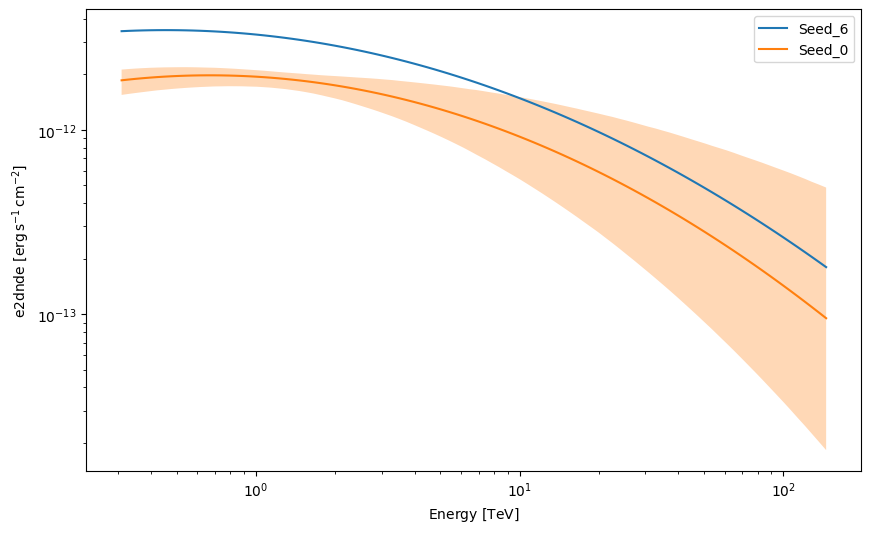

In [23]:
fig, ax = plt.subplots(figsize=(10,6))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

for model, color in zip(new_models[2:], colors):
    plot_kwargs = dict(
        energy_bounds=[0.3, 150]*u.TeV,
        sed_type="e2dnde",
        ax=ax,
    )
    model.spectral_model.plot(**plot_kwargs, label=model.name, ls="-", color=color)
    model.spectral_model.plot_error(facecolor=color, alpha=0.3, **plot_kwargs)
plt.legend()
plt.show()

Here we can plot the number of predicted counts for each model and
for the background in our dataset. In order to do this, we can use
the `~gammapy.visualization.plot_npred_signal` function.



In [24]:
plot_npred_signal?

Object `plot_npred_signal` not found.


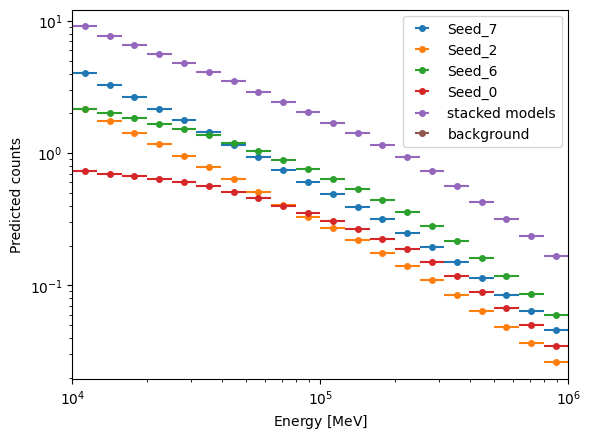

In [25]:
from gammapy.visualization import plot_npred_signal

plot_npred_signal(datasets[0], model_names=new_models.names)
plt.show()